# Using Machine Learning Techniques to Predict the Winner of NBA Games

# Fetching the dataset from the balldontlie API.

In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split
from datetime import datetime, timezone

# Gets a list of years from 2013 to 2023.
current_year = datetime.now().year
years = list(range(current_year-10, current_year+1))

# Base API endpoint
base_url = 'https://www.balldontlie.io/api/v1/games'

# Additional parameter for postseason so that postseason games are not included.
postseason_param = 'postseason=false'

# List to store each season dataframe.
nba_games = []

# Loop through seasons
for season in years:
    # Initialize variables for pagination
    current_page = 1
    total_pages = float('inf')  # Initialize to positive infinity
    nba_games_df = None
    
    all_data = [] # Array containing the rows for season currently in the loop

    while current_page is not None:
        # Construct the API endpoint URL with the current page and postseason parameter
        api_endpoint = f'{base_url}?seasons[]={season}&page={current_page}&per_page=100&{postseason_param}'

        # Make a GET request to the API
        response = requests.get(api_endpoint)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse the JSON data
            json_data = response.json()

            # Append the data for the current page to the list
            all_data.extend(json_data.get('data', []))

            # Update pagination variables
            current_page = json_data['meta']['next_page']
        else:
            # Print an error message if the request was not successful
            print(f"Error: {response.status_code}, {response.text}")
            break  # Exit the loop if there's an error

        # Pause for 3 seconds after each API request
        time.sleep(3)

    df_data = [{
        'season': game['season'],
        'date': game['date'],
        'h_team_id': game['home_team']['id'],
        'a_team_id': game['visitor_team']['id'],
        'h_score': game['home_team_score'],
        'a_score': game['visitor_team_score']}
        for game in all_data]

    # Creating a DataFrame
    nba_games_df = pd.DataFrame(df_data)

    # Display the DataFrame
    nba_games_df = nba_games_df.sort_values(by='date')
    nba_games_df = nba_games_df.tail(1230) # Each regular season typically has 1230 games. So, this excludes pre-season games.

    # Append the DataFrame to the list
    nba_games.append(nba_games_df)

# Concatenate all the DataFrames together
nba_games_df = pd.concat(nba_games, ignore_index=True)

# Assuming final_dataframe is your DataFrame
# Convert the "date" column to datetime format with UTC timezone
nba_games_df['date'] = pd.to_datetime(nba_games_df['date']).dt.tz_convert('UTC')

# Get the current date with UTC timezone
current_date = datetime.now(timezone.utc)

# Filter rows with a date less than the current date
nba_games_df = nba_games_df[nba_games_df['date'] < current_date]

# All current season games and ones that have not been played were fetched. This filters the dataframe so that only games that
# have been played are in the dataframe
nba_games_df = nba_games_df[(nba_games_df['h_score']>0)]

# Get score differences and create the h_win column.
nba_games_df['h_score_dif'] = nba_games_df['h_score'] - nba_games_df['a_score']
nba_games_df['a_score_dif'] = nba_games_df['a_score'] - nba_games_df['h_score']
nba_games_df['h_win'] = (nba_games_df['h_score'] > nba_games_df['a_score']).astype(int)

nba_games_df

C:\Users\sfedd\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,season,date,h_team_id,a_team_id,h_score,a_score,h_score_dif,a_score_dif,h_win
0,2013,2013-10-29 00:00:00+00:00,16,5,107,95,12,-12,1
1,2013,2013-10-29 00:00:00+00:00,14,13,116,103,13,-13,1
2,2013,2013-10-29 00:00:00+00:00,12,22,97,87,10,-10,1
3,2013,2013-10-30 00:00:00+00:00,10,14,125,94,31,-31,1
4,2013,2013-10-30 00:00:00+00:00,9,30,113,102,11,-11,1
...,...,...,...,...,...,...,...,...,...
12295,2023,2023-12-08 00:00:00+00:00,15,18,103,127,-24,24,0
12296,2023,2023-12-08 00:00:00+00:00,16,6,99,111,-12,12,0
12297,2023,2023-12-08 00:00:00+00:00,3,30,124,97,27,-27,1
12298,2023,2023-12-08 00:00:00+00:00,23,1,125,114,11,-11,1


# Calculate the Elo ratings

In [2]:
def calculate_dynamic_k(mov_winner, elo_difference_winner):
    """
    Calculate dynamic K value based on margin of victory and Elo difference.

    :param mov_winner: Margin of victory for the winning team
    :param elo_difference_winner: Elo difference between the winning and losing teams
    :return: Dynamic K value
    """
    return 20 * ((mov_winner + 3) ** 0.8) / (7.5 + 0.006 * elo_difference_winner)

def update_elo_dynamic_k(winner_elo, loser_elo, mov_winner, elo_difference_winner):
    """
    Update Elo ratings based on the result of a game with dynamic K value.

    :param winner_elo: Elo rating of the winning team
    :param loser_elo: Elo rating of the losing team
    :param mov_winner: Margin of victory for the winning team
    :param elo_difference_winner: Elo difference between the winning and losing teams
    :return: Updated Elo ratings for both teams
    """
    k = calculate_dynamic_k(mov_winner, elo_difference_winner)

    winner_prob = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    loser_prob = 1 - winner_prob

    winner_elo_new = winner_elo + k * (1 - winner_prob)
    loser_elo_new = loser_elo + k * (0 - loser_prob)

    return winner_elo_new, loser_elo_new

nba_games_df['h_elo'] = 1500  # Initialize to default Elo rating
nba_games_df['a_elo'] = 1500  # Initialize to default Elo rating

# Dictionary to store Elo ratings for each team
elo_scores = {}

# Calculate historical Elo scores for each game with dynamic K value
for index, row in nba_games_df.iterrows():
    home_team = row['h_team_id']
    away_team = row['a_team_id']

    # Get the historical Elo rating leading up to, but not including, the current game
    home_elo = elo_scores.get(home_team, 1500)
    away_elo = elo_scores.get(away_team, 1500)

    h_prev_gms = nba_games_df[(nba_games_df['season']==row['season'])&((nba_games_df['h_team_id']==home_team)|(nba_games_df['a_team_id']==home_team))&(nba_games_df['date']<row['date'])]
    a_prev_gms = nba_games_df[(nba_games_df['season']==row['season'])&((nba_games_df['a_team_id']==away_team)|(nba_games_df['a_team_id']==away_team))&(nba_games_df['date']<row['date'])]


    if len(h_prev_gms)==0 and len(nba_games_df[nba_games_df['season']==(row['season']-1)]):
        home_elo = (home_elo*0.75)+(0.25*1505)
    if len(a_prev_gms)==0 and len(nba_games_df[nba_games_df['season']==(row['season']-1)]):
        away_elo = (away_elo*0.75)+(0.25*1505)

    # Assign the historical Elo rating to the DataFrame
    nba_games_df.at[index, 'h_elo'] = home_elo
    nba_games_df.at[index, 'a_elo'] = away_elo

    # Update Elo ratings based on the game result with dynamic K value
    if row['h_win'] == 1:
        home_elo, away_elo = update_elo_dynamic_k(home_elo, away_elo, row['h_score_dif'], home_elo - away_elo)
    else:
        away_elo, home_elo = update_elo_dynamic_k(away_elo, home_elo, row['a_score_dif'], away_elo - home_elo)

    # Update the dictionary with the new Elo ratings
    elo_scores[home_team] = home_elo
    elo_scores[away_team] = away_elo

# Get the differences between the home and away team's Elo ratings for each game
nba_games_df['elo_dif'] = nba_games_df['h_elo'] - nba_games_df['a_elo']

nba_games_df

,season,date,h_team_id,a_team_id,h_score,a_score,h_score_dif,a_score_dif,h_win,h_elo,a_elo,elo_dif
0,2013,2013-10-29 00:00:00+00:00,16,5,107,95,12,-12,1,1500,1500,0
1,2013,2013-10-29 00:00:00+00:00,14,13,116,103,13,-13,1,1500,1500,0
2,2013,2013-10-29 00:00:00+00:00,12,22,97,87,10,-10,1,1500,1500,0
3,2013,2013-10-30 00:00:00+00:00,10,14,125,94,31,-31,1,1500,1512,-12
4,2013,2013-10-30 00:00:00+00:00,9,30,113,102,11,-11,1,1500,1500,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12295,2023,2023-12-08 00:00:00+00:00,15,18,103,127,-24,24,0,1454,1614,-160
12296,2023,2023-12-08 00:00:00+00:00,16,6,99,111,-12,12,0,1535,1551,-16
12297,2023,2023-12-08 00:00:00+00:00,3,30,124,97,27,-27,1,1559,1372,187
12298,2023,2023-12-08 00:00:00+00:00,23,1,125,114,11,-11,1,1619,1502,117


# Display Elo rating time series for the Warriors, Cavaliers, and Magic

C:\Users\sfedd\AppData\Local\Temp/ipykernel_11444/2924815286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magic_elo['elo_rating'] = magic_elo.apply(lambda row: row['h_elo'] if row['h_team_id'] == 22 else row['a_elo'], axis=1)
C:\Users\sfedd\AppData\Local\Temp/ipykernel_11444/2924815286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cavs_elo['elo_rating'] = cavs_elo.apply(lambda row: row['h_elo'] if row['h_team_id'] == 6 else row['a_elo'], axis=1)
C:\Users\sfedd\AppData\Local\Temp/ipykernel_11444

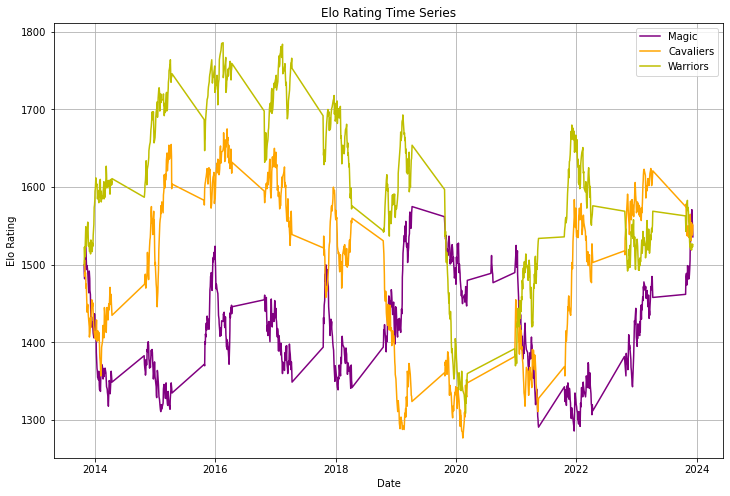

In [3]:
magic_elo = nba_games_df[(nba_games_df['h_team_id']==22)|(nba_games_df['a_team_id']==22)]
cavs_elo = nba_games_df[(nba_games_df['h_team_id']==6)|(nba_games_df['a_team_id']==6)]
warriors_elo = nba_games_df[(nba_games_df['h_team_id']==10)|(nba_games_df['a_team_id']==10)]

magic_elo['elo_rating'] = magic_elo.apply(lambda row: row['h_elo'] if row['h_team_id'] == 22 else row['a_elo'], axis=1)
cavs_elo['elo_rating'] = cavs_elo.apply(lambda row: row['h_elo'] if row['h_team_id'] == 6 else row['a_elo'], axis=1)
warriors_elo['elo_rating'] = warriors_elo.apply(lambda row: row['h_elo'] if row['h_team_id'] == 10 else row['a_elo'], axis=1)

magic_elo = magic_elo[['date', 'elo_rating']]
cavs_elo = cavs_elo[['date', 'elo_rating']]
warriors_elo = warriors_elo[['date', 'elo_rating']]
magic_elo

# Assuming you have the dataframes: bulls_elo, pistons_elo, warriors_elo

# Convert 'date' column to datetime type
magic_elo['date'] = pd.to_datetime(magic_elo['date'])
cavs_elo['date'] = pd.to_datetime(cavs_elo['date'])
warriors_elo['date'] = pd.to_datetime(warriors_elo['date'])

# Plotting
plt.figure(figsize=(12, 8))

# Plot for Bulls
plt.plot(magic_elo['date'], magic_elo['elo_rating'], label='Magic', linestyle='-', color='purple')

# Plot for Pistons
plt.plot(cavs_elo['date'], cavs_elo['elo_rating'], label='Cavaliers', linestyle='-', color='orange')

# Plot for Warriors
plt.plot(warriors_elo['date'], warriors_elo['elo_rating'], label='Warriors', linestyle='-', color='y')

# Customize the plot
plt.title('Elo Rating Time Series')
plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()

The time series looks like what we would expect. The warriors and cavaliers during the years they met in the finals have
high Elo ratings. When Lebron left the Cavaliers in 2019, we see a great fall in their Elo ratings. Although the warriors had
super teams and some of the best teams of all time during this span, this supports the notion that the Western conference was
stronger than the Eastern conference during this time period.
When Steph Curry broke his thumb and missed most of the 2020 season, we see their Elo ratings went way down. 
We also see that the magic, considered one of the worst teams this past decade, have very low Elo ratings.
From this graph, we can see that teams tend to regress to the mean of 1500 and that teams usually do not suddenly drop off in 
Elo ratings

In [7]:
# Gets a list of years from 2013 to 2023.
current_year = datetime.now().year
years = list(range(current_year-10, current_year+1))

# The current 2023-24 NBA season. We will be validating the model with it.
nba_games_df_2023 = nba_games_df[nba_games_df['season']==years[-1]]

# The 2014-15 to 2022-23 NBA seasons we will be training and testing the model with.
nba_games_df_2014_2022 = nba_games_df[(nba_games_df['season']<years[-1])&(nba_games_df['season']>years[0])]

nba_games_df_2014_2022

,season,date,h_team_id,a_team_id,h_score,a_score,h_score_dif,a_score_dif,h_win,h_elo,a_elo,elo_dif
1230,2014,2014-10-28 00:00:00+00:00,27,7,101,100,1,-1,1,1622,1571,51
1231,2014,2014-10-28 00:00:00+00:00,19,22,101,84,17,-17,1,1457,1383,74
1232,2014,2014-10-28 00:00:00+00:00,14,11,90,108,-18,18,0,1424,1585,-161
1233,2014,2014-10-29 00:00:00+00:00,12,23,103,91,12,-12,1,1510,1329,181
1234,2014,2014-10-29 00:00:00+00:00,4,17,108,106,2,-2,1,1547,1331,216
...,...,...,...,...,...,...,...,...,...,...,...,...
11975,2022,2023-04-11 00:00:00+00:00,16,1,105,116,-11,11,0,1526,1514,12
11976,2022,2023-04-12 00:00:00+00:00,28,5,105,109,-4,4,0,1562,1549,13
11977,2022,2023-04-12 00:00:00+00:00,19,21,118,123,-5,5,0,1536,1509,27
11978,2022,2023-04-14 00:00:00+00:00,16,5,102,91,11,-11,1,1514,1555,-41


# Visualize the Data

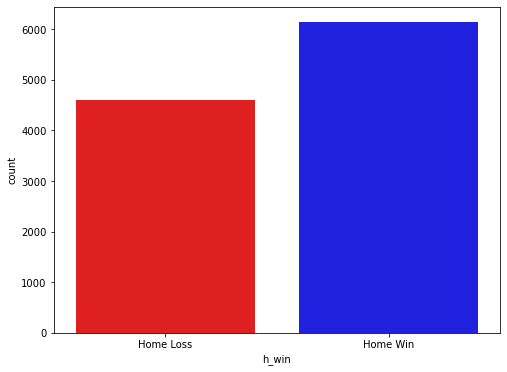

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a countplot for the 'h_win' column
plt.figure(figsize=(8, 6))
sns.countplot(x='h_win', data=nba_games_df_2014_2022, palette={0: 'red', 1: 'blue'})

plt.xticks([0, 1], ['Home Loss', 'Home Win'])

# Show the plot
plt.show()

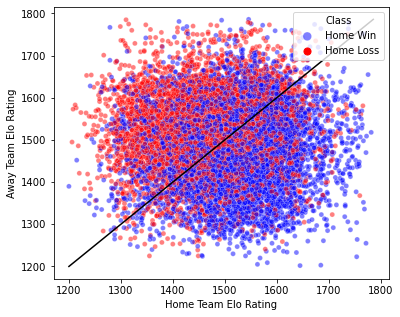

In [9]:
# Create a scatter plot
plt.figure(figsize=(6, 5))

# Scatter plot
sns.scatterplot(x='h_elo', y='a_elo', hue='h_win', data=nba_games_df, palette={0: '#FF0000', 1: '#0000FF'}, alpha=.5, s=25)

# Define xlim based on the min and max values of 'h_elo' and 'a_elo'
xlim = [min(nba_games_df['h_elo'].min(), nba_games_df['a_elo'].min()),
        max(nba_games_df['h_elo'].max(), nba_games_df['a_elo'].max())]

# Plot the line y=x
plt.plot(xlim, xlim, color='black', label='_nolegend_')

# Set plot labels and title
plt.xlabel('Home Team Elo Rating')
plt.ylabel('Away Team Elo Rating')

# Display the legend within the plot in the upper right corner.
legend = plt.legend(title='Class', labels=['Home Win', 'Home Loss'], loc='upper right')
legend.legendHandles[0]._sizes = [75]
legend.legendHandles[1]._sizes = [50]

# Show the plot
plt.show()

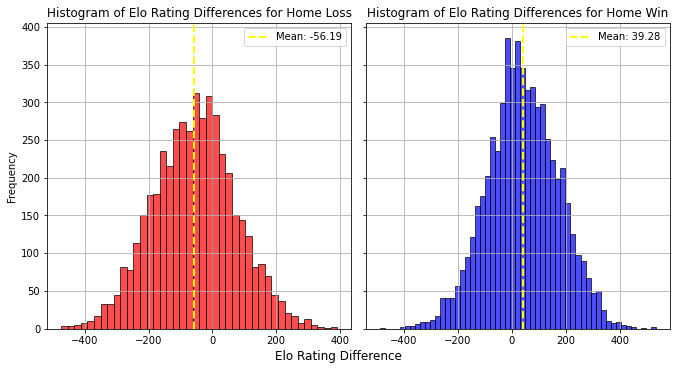

In [10]:
home_losses = nba_games_df_2014_2022[nba_games_df_2014_2022['h_win'] == 0]['elo_dif']
home_wins = nba_games_df_2014_2022[nba_games_df_2014_2022['h_win'] == 1]['elo_dif']

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 5), sharey=True)

# Plot for home loss class
axes[0].hist(home_losses, bins='auto', alpha=0.7, color='red', edgecolor='black')
axes[0].set_title('Histogram of Elo Rating Differences for Home Loss')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot for home win class
axes[1].hist(home_wins, bins='auto', alpha=0.7, color='blue', edgecolor='black')
axes[1].set_title('Histogram of Elo Rating Differences for Home Win')
axes[1].grid(True)

# Add common x-axis label above the subplots
fig.text(0.5, 0, 'Elo Rating Difference', ha='center', va='center', fontsize=12)

# Add dotted vertical lines at the means
mean0 = home_losses.mean()
mean1 = home_wins.mean()
axes[0].axvline(mean0, color='yellow', linestyle='dashed', linewidth=2, label=f'Mean: {mean0:.2f}')
axes[1].axvline(mean1, color='yellow', linestyle='dashed', linewidth=2, label=f'Mean: {mean1:.2f}')

# Add legend for the dotted lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

# Train and Test the Models

## Train and test the Gaussian Naive Bayes Model

Average Accuracy over 10-fold cross-validation: 0.6408197478556581


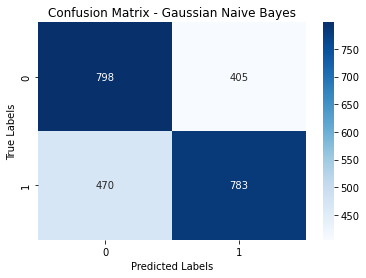

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.66      0.65      1203
           1       0.66      0.62      0.64      1253

    accuracy                           0.64      2456
   macro avg       0.64      0.64      0.64      2456
weighted avg       0.64      0.64      0.64      2456



In [11]:
from sklearn.naive_bayes import GaussianNB

# Define features and target.
X = nba_games_df_2014_2022[['elo_dif']]
y = nba_games_df_2014_2022['h_win']

# Initialize Gaussian Naive Bayes model
gnb_model = GaussianNB()

# Apply SMOTE to the entire dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Perform 10-fold cross-validation
cross_val_results = cross_val_score(gnb_model, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Calculate average accuracy
average_accuracy = np.mean(cross_val_results)
print(f'Average Accuracy over 10-fold cross-validation: {average_accuracy}')

# Plot confusion matrix for one of the folds
_, X_test, _, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
gnb_model.fit(X_resampled, y_resampled)
y_pred = gnb_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

# Display classification report for one of the folds
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

C:\Users\sfedd\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


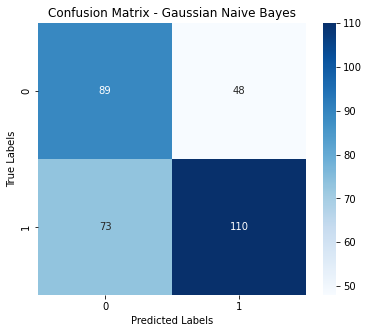

Classification Report for 2023:
               precision    recall  f1-score   support

           0       0.55      0.65      0.60       137
           1       0.70      0.60      0.65       183

    accuracy                           0.62       320
   macro avg       0.62      0.63      0.62       320
weighted avg       0.63      0.62      0.62       320



In [16]:
# Reshape the array to make it 2D
elo_dif_2023 = nba_games_df_2023[['elo_dif']].values.reshape(-1, 1)

# Predict outcomes for 2023 using the trained model
y_pred_2023 = gnb_model.predict(elo_dif_2023)

# Compare predictions with actual outcomes
actual_outcomes_2023 = nba_games_df_2023['h_win']

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_outcomes_2023, y_pred_2023)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

# Generate and display the classification report
class_report_2023 = classification_report(actual_outcomes_2023, y_pred_2023)
print("Classification Report for 2023:\n", class_report_2023)

## Train and Test the Logistic Regression Model

Average Accuracy over 10-fold cross-validation with SMOTE: 0.6426134025681663


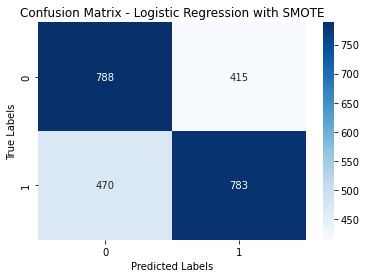

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.66      0.64      1203
           1       0.65      0.62      0.64      1253

    accuracy                           0.64      2456
   macro avg       0.64      0.64      0.64      2456
weighted avg       0.64      0.64      0.64      2456



In [13]:
from sklearn.linear_model import LogisticRegression

# Define features and target variable
X = nba_games_df_2014_2022[['elo_dif']]
y = nba_games_df_2014_2022['h_win']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Initialize Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Perform 10-fold cross-validation on the resampled data
cross_val_results = cross_val_score(logreg_model, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Calculate average accuracy
average_accuracy = np.mean(cross_val_results)
print(f'Average Accuracy over 10-fold cross-validation with SMOTE: {average_accuracy}')

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the Logistic Regression model on the training set
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

# Display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

C:\Users\sfedd\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


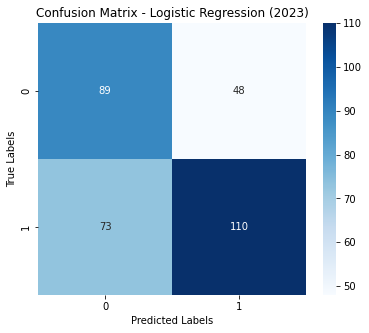

Classification Report for 2023:
               precision    recall  f1-score   support

           0       0.55      0.65      0.60       137
           1       0.70      0.60      0.65       183

    accuracy                           0.62       320
   macro avg       0.62      0.63      0.62       320
weighted avg       0.63      0.62      0.62       320



In [14]:
# Reshape the array to make it 2D
elo_dif_2023 = nba_games_df_2023['elo_dif'].values.reshape(-1, 1)

# Predict outcomes for 2023 using the trained model
y_pred_2023 = logreg_model.predict(elo_dif_2023)

# Compare predictions with actual outcomes
actual_outcomes_2023 = nba_games_df_2023['h_win']

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_outcomes_2023, y_pred_2023)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (2023)')
plt.show()

# Generate and display the classification report
class_report_2023 = classification_report(actual_outcomes_2023, y_pred_2023)
print("Classification Report for 2023:\n", class_report_2023)

# Probability of home team winning

This is where the models become useful. Not only do they classify if the home team won, they also provides the probabilitiy that
the home team will win.

In [17]:
def predict_home_team_win_probability(elo_diff):
    # Reshape the input for the model prediction
    elo_diff_array = np.array([[elo_diff]])

    # Predict the probability using the Gaussian Naive Bayes model
    probability = gnb_model.predict_proba(elo_diff_array)[:, 1]

    # Return the result
    return probability[0]

# Example usage with Elo difference of 100
elo_rating_difference = 100
probability = predict_home_team_probability(elo_rating_difference)
print(f"Probability of Home Team Winning with Elo difference {elo_rating_difference}: {probability:.2%}")

Probability of Home Team Winning with Elo difference 100: 64.50%


C:\Users\sfedd\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [20]:
# Function to predict the probability of home team winning
def predict_home_team_win_probability(elo_diff):
    # Reshape the input for the model prediction
    elo_diff_array = np.array([[elo_diff]])

    # Predict the probability using the Logistic Regression model
    probability = logreg_model.predict_proba(elo_diff_array)[:, 1]

    # Return the result
    return probability[0]

# Example usage with Elo difference of -150
elo_rating_difference = -150
probability = predict_home_team_probability(elo_rating_difference)
print(f"Probability of Home Team Winning with Elo difference {elo_rating_difference}: {probability:.2%}")

Probability of Home Team Winning with Elo difference -150: 30.64%


C:\Users\sfedd\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
